## Kaggle Reuse Experiment
In this notebook, we make the plot in Figure 8 of Section 6.4.

Experiment result is located here:

'./experiment_results/remote/reuse/kaggle_home_credit/cloud-41/2019-10-19/09-49.csv'


In [1]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
import os
import matplotlib2tikz
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_style({'grid.color': '.5'})
FONT_SIZE = 25
LW=4
plt.rcParams.update({
    "lines.markersize": 13,
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,   
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": FONT_SIZE,     
    "font.size": FONT_SIZE,
    "legend.fontsize": 20, 
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,
    #"figure.figsize": figsize(1.0), 
     "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
})
plt.rc('hatch', color='white', linewidth=LW)

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results'


SYSTEM_COLOR = sns.color_palette()[0]
ALL_MAT_COLOR = sns.color_palette()[1]
HELIX_COLOR = sns.color_palette()[2]
ALL_COMPUTE_COLOR = sns.color_palette()[3]
BOTTOMUP_COLOR = sns.color_palette()[4]

WRITE_DIRECTORY_ROOT = \
'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/papers/images/experiment-results'

output_directory = WRITE_DIRECTORY_ROOT + '/kaggle_home_credit/reuse'
def create_folder(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
def savefig(filename):
    plt.savefig('{}.pgf'.format(filename), bbox_inches='tight')
    plt.savefig('{}.pdf'.format(filename), bbox_inches='tight')
    plt.savefig('{}.eps'.format(filename), bbox_inches='tight')

In [2]:
result_folder = ROOT_RESULT_FOLDER + '/remote/reuse/kaggle_home_credit'
# IN PAPER = result_folder + '/cloud-41/2019-10-19/09-49.csv'
result_file = result_folder + '/cloud-41/2020-02-04/09-50.csv'

In [3]:
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'workload', 'mat_type','reuse_type', 'budget','run_time'
]
execution_order = {
    'start_here_a_gentle_introduction': 1,
    'introduction_to_manual_feature_engineering': 2,
    'introduction_to_manual_feature_engineering_p2': 3,
    'fork_cridata_start_here_a_gentle_introduction': 4,
    'fork_taozhongxiao_start_here_a_gentle_introduction': 5,
    'fork_introduction_to_manual_feature_engineering': 6,
    'fork_introduction_to_manual_feature_engineering_p2': 7,
    'fork_join_start_here_intro': 8
}
reuse_map = {'linear':'LN','all_mat':'ALL_M', 'all_compute':'ALL_C', 'bottomup':'BU', 'helix':'HL'}
reuse_result = pd.read_csv(result_file, header=None, names=HEADERS)
reuse_result['workload_order'] = reuse_result['workload'].replace(execution_order)
reuse_result['reuse_type'] = reuse_result['reuse_type'].replace(reuse_map)
reuse_result = reuse_result[reuse_result.reuse_type != 'BU']
reuse_result['cumulative_run_time'] = reuse_result.groupby(['exp_id', 'reuse_type'])['run_time'].apply(lambda x: x.cumsum())

In [4]:
simple_df = reuse_result[reuse_result.mat_type == 'simple']
ss_df = reuse_result[reuse_result.mat_type == 'storage_aware']

In [5]:
simple_df = simple_df.groupby(['workload_order','reuse_type','mat_type'])['cumulative_run_time'].mean().reset_index()
ss_df = ss_df.groupby(['workload_order','reuse_type','mat_type'])['cumulative_run_time'].mean().reset_index()

In [6]:
df = simple_df[simple_df.reuse_type == 'ALL_C'][['workload_order','cumulative_run_time']]
simple_df = simple_df.merge(df, on='workload_order', suffixes=('','_ALL_C'))
simple_df['speed_up']=simple_df['cumulative_run_time_ALL_C']/simple_df['cumulative_run_time']

In [7]:
df = ss_df[ss_df.reuse_type == 'ALL_C'][['workload_order','cumulative_run_time']]
ss_df = ss_df.merge(df, on='workload_order', suffixes=('','_ALL_C'))
ss_df['speed_up']=ss_df['cumulative_run_time_ALL_C']/ss_df['cumulative_run_time']

In [8]:
result_folder = ROOT_RESULT_FOLDER + '/remote/reuse_benchmarking/kaggle_home_credit'
# IN PAPER = result_folder + '/cloud-41/2019-10-19/09-49.csv'
result_file = result_folder + '/cloud-41/2020-02-14/23-47.csv'

HEADERS = [
   'exp_id', 'n', 'workload_size','LN', 'HL'
]

reuse_result = pd.read_csv(result_file, header=None, names=HEADERS)
reuse_df = pd.melt(reuse_result, id_vars=['exp_id','workload_size', 'n'], var_name ='type',value_name='run_time', value_vars=['LN','HL'])

reuse_df['cumulative_run_time'] = reuse_df.groupby(['exp_id', 'type'])['run_time'].apply(lambda x: x.cumsum())

                   

In [9]:
def plot_reuse_overhead(df,ax):
#     plt.figure(figsize=(8, 4))
    plot = sns.lineplot(
        data=df,
        ax=ax,
        estimator='mean',
        x='n',
        y='cumulative_run_time',
        hue='type',
        style='type',
        lw=LW,
        ci='sd',
        hue_order=['LN', 'HL'],
        dashes={
            'LN': (1, 0),
            'HL': (2, 2),
        },
        palette={
            'LN': SYSTEM_COLOR,
            'HL':HELIX_COLOR,
        },
        legend='brief')
    plot.get_legend().remove()
    plot.set_xlabel('Number of Workloads\n\\textbf{{(d) LN vs HL Overhead}}')
    plot.set_ylabel('Cumulative \nOverhead (s)')
    
    handles = []
    labels = ['LN','HL']
    from matplotlib.lines import Line2D
    handles.append(Line2D([0], [1],
                        color=SYSTEM_COLOR,
                        lw=5,
                        dashes=(1, 0)))
    
    handles.append(Line2D([0], [1],
                        color=HELIX_COLOR,
                        lw=5,
                        dashes=(2, 2)))
    

    plt.xscale('log')
    plot.set_xticks([ 1.00000000e-0,   1.00000000e+01,   1.00000000e+02, 1.00000000e+03,   1.00000000e+04])
    plot.set_yticks([0, 1000, 2000, 3000 ])
    plot.yaxis.set_major_formatter(ticker.EngFormatter(sep=''))
    ax.tick_params(axis='x',pad=-1.5)
    legend = plot.legend(
        handles,
        labels,
        frameon=True,
        loc='upper left',
        handlelength=2,
        handletextpad=0.1,
        numpoints=1,
        ncol=1,
        columnspacing=0.5)
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(2.0)
    
    return plot

In [10]:
def plot_executions_times(df,ax, mat_type):
    plot = sns.lineplot(
        data=df,
        x='workload_order',
        y='cumulative_run_time',
        hue='reuse_type',
        style='reuse_type',
        ax=ax,
        markers={
            'LN': "o",
            'HL':'X',
            'ALL_M': "^",
            'ALL_C': 'v'
        },
        lw=LW,
        ci='sd',
        hue_order=['LN', 'HL', 'ALL_M', 'ALL_C'],
        dashes={
            'LN': (1, 0),
            'HL': (2, 2),
            'ALL_M': (3, 1),
            'ALL_C': (1, 1)
        },
        palette={
            'LN': SYSTEM_COLOR,
            'HL':HELIX_COLOR,
            'ALL_M': ALL_MAT_COLOR,
            'ALL_C': ALL_COMPUTE_COLOR
        },
        legend='brief')
    
    plot.set_xlabel('Workload\n{}'.format(mat_type))
    plot.set_ylabel('Cumulative \nRun Time (s)')
    plot.set_ylim((0, 2200))
    plot.set_yticks([0, 500, 1000, 1500, 2000])
    plot.set_xticks(range(1,9))
    plot.set_xticklabels(range(1,9))
    plot.yaxis.set_major_formatter(ticker.EngFormatter(sep=''))
    ax.tick_params(axis='both', which='major', pad=-2)
    
    plot.get_legend().remove()
    handles = []
    labels = ['LN', 'HL', 'ALL\_M', 'ALL\_C']
    from matplotlib.lines import Line2D
    handles.append(Line2D([0], [1],
                        color=SYSTEM_COLOR,
                        lw=LW,
                        dashes=(1, 0),
                        marker="o",
                        markersize=15))
    handles.append(Line2D([0], [1],
                        color=HELIX_COLOR,
                        lw=LW,
                        dashes=(2, 2),
                        marker="X",
                        markersize=15))
    handles.append(Line2D([0], [1],
                        color=ALL_MAT_COLOR,
                        lw=LW,
                        dashes=(3, 1),
                        marker="^",
                        markersize=15))
    handles.append(Line2D([0], [1],
                        color=ALL_COMPUTE_COLOR,
                        lw=LW,
                        dashes=(1, 1),
                        marker="v",
                        markersize=15))
    legend = plot.legend(
        handles,
        labels,
        borderpad=0.2,
        frameon=True,
        loc='upper left',
        handlelength=2.5,
        handletextpad=0.1,
        numpoints=1,
        ncol=2,
        columnspacing=0.5)
    
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(2.0)
    
    return plot

In [11]:
def plot_speed_up_times(df, ax):
    #plt.figure(figsize=(8, 4))
    plot = sns.lineplot(
        data=df,
        x='workload_order',
        y='speed_up',
        hue='reuse_type',
        style='reuse_type',
        ax=ax,
        markers={
            'LN': "o",
            'HL':'X',
            'ALL_M': "^",
        },
        lw=LW,
        ci='sd',
        dashes={
            'LN': (1, 0),
            'HL': (2, 2),
            'ALL_M': (3, 1)
        },
        palette={
            'LN': SYSTEM_COLOR,
            'HL':HELIX_COLOR,
            'ALL_M': ALL_MAT_COLOR
        },
        legend='brief')

    plot.set_xlabel('Workload\n{}'.format('\\textbf{{(c) Speedup vs ALL\_C}}'))
    plot.set_ylabel('Cumulative \nSpeedup')
    plot.set_xticks(range(1,9))
    plot.set_xticklabels(range(1,9))
    plot.yaxis.set_major_formatter(ticker.EngFormatter(sep=''))
    ax.get_legend().remove()
    ax.tick_params(axis='both', which='major', pad=-2)
    
    handles = []
    labels = ['LN', 'HL', 'ALL\_M']
    from matplotlib.lines import Line2D
    handles.append(Line2D([0], [1],
                        color=SYSTEM_COLOR,
                        lw=LW,
                        dashes=(1, 0),
                        marker="o",
                        markersize=15))
    handles.append(Line2D([0], [1],
                        color=HELIX_COLOR,
                        lw=LW,
                        dashes=(2, 2),
                        marker="X",
                        markersize=15))
    handles.append(Line2D([0], [1],
                        color=ALL_MAT_COLOR,
                        lw=LW,
                        dashes=(3, 1),
                        marker="^",
                        markersize=15))
    
    legend = plot.legend(
        handles,
        labels,
        frameon=True,
        loc='upper left',
        handlelength=2,
        handletextpad=0.1,
        numpoints=1,
        ncol=1,
        columnspacing=0.5)
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(2.0)
    
    return plot

In [12]:
s_df = ss_df[['workload_order','reuse_type', 'speed_up']]
s_df = s_df[s_df.reuse_type !='ALL_C']

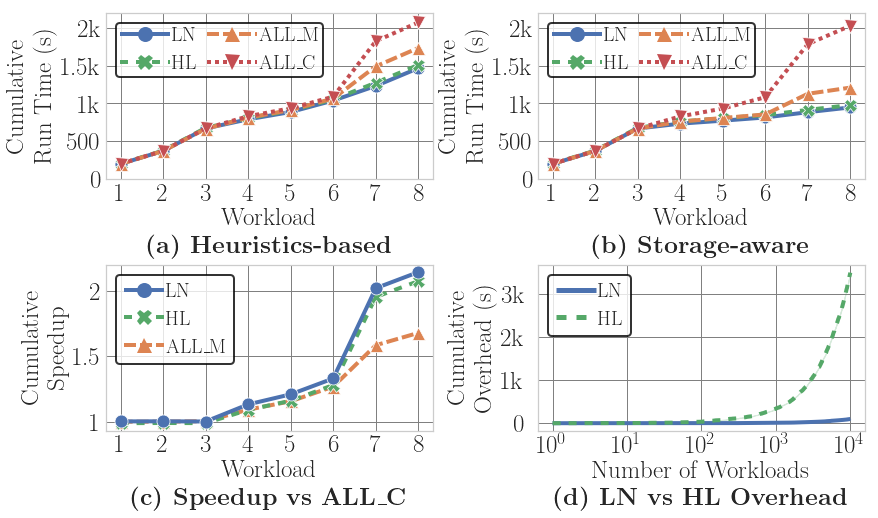

In [13]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(12, 7)) 
gs = GridSpec(2, 4)

ax = plt.subplot(gs[0, 0:2])
p1=plot_executions_times(simple_df, ax,'\\textbf{{(a) Heuristics-based}}')

ax = plt.subplot(gs[0,2:4])
p2=plot_executions_times(ss_df, ax, '\\textbf{{(b) Storage-aware}}')

ax = plt.subplot(gs[1,0:2])
p2=plot_speed_up_times(s_df, ax)

ax = plt.subplot(gs[1,2:4])
p1=plot_reuse_overhead(reuse_df, ax)

fig.tight_layout(pad=0,h_pad=0,w_pad=0)
#savefig(output_directory+'/reuse-times-perworkload-speedups')

In [14]:
s_df

,workload_order,reuse_type,speed_up
1,1,ALL_M,0.998450
2,1,HL,0.987051
3,1,LN,1.000760
5,2,ALL_M,0.998952
6,2,HL,0.988629
7,2,LN,1.001537
9,3,ALL_M,1.002154
10,3,HL,0.987571
11,3,LN,1.000051
13,4,ALL_M,1.090366
